In [1]:
# Import

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Funkcje pomocnicze

def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))

In [3]:
# Wczytanie danych
train_raw = pd.read_csv('../input/titanic/train.csv')
test_raw = pd.read_csv('../input/titanic/test.csv')
test_ids = test_raw['PassengerId'].values

# Łączenie danych w jeden zbiór
train_raw['train'] = 1
test_raw['train'] = 0
data = train_raw.append(test_raw, sort=False)

In [4]:
# Wyświetlenie podglądu danych treningowych
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


In [5]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['train']]
# Zamiana danych kategorycznym na numeryczne.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'], 10, labels=False)

In [6]:
# Dzielenie danych .
train = data.query('train == 1')
test = data.query('train == 0')

# Wyrzucenie brakujących danych.
train.dropna(axis=0, inplace=True)
labels = train[target].values

In [7]:
# Ponowne wyświetlenie podglądu danych treningowych
train.head(3)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2.0,1.0,7.2500,0,3,1,1,0.0,1
1,7.0,2.0,71.2833,0,1,0,1,1.0,1
2,4.0,1.0,7.9250,0,3,0,0,1.0,1


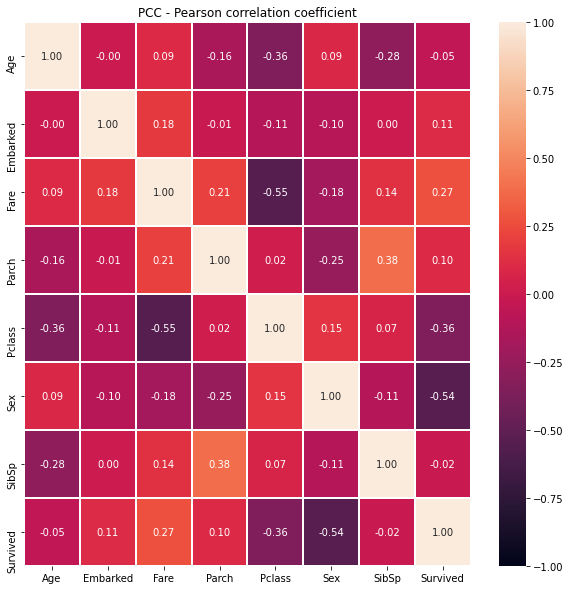

In [8]:
columns = train[features + [target]].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)

# Użycie korelacji Pearsona  na każdą parę.
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = pearsonr(train.loc[:, columns[col_a]], train.loc[:,  columns[col_b]])[0]
        
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=.2)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

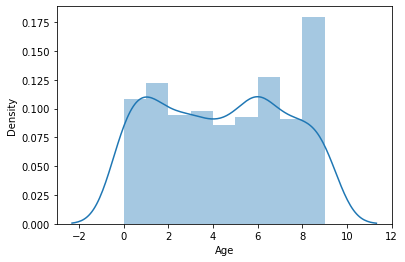

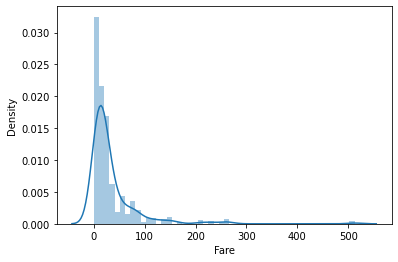

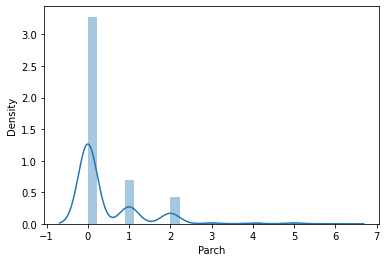

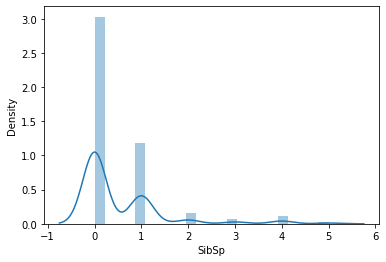

In [9]:
# Rozkład poszczególnych cech
continuous_numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
for feature in continuous_numeric_features:
    sns.distplot(train[feature])
    plt.show()

In [10]:
train.drop(['train', target, 'Pclass'], axis=1, inplace=True)
test.drop(['train', target, 'Pclass'], axis=1, inplace=True)

In [11]:
# Podział danych na treningowe i walidacyjne
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

In [12]:
# Ponowne wyświetlenie podglądu danych treningowych
X_train.head(3)

,Age,Embarked,Fare,Parch,Sex,SibSp
830,1.0,2.0,14.4542,0,0,1
566,1.0,1.0,7.8958,0,1,0
149,7.0,1.0,13.0000,0,1,0


In [13]:
# Ponowny podział danych treningowych
X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train, Y_train, test_size=0.3, random_state=12)

In [14]:
# Dopasowywanie pierwszej części danych 
classifier = GaussianNB()
classifier.fit(X_train2, Y_train2)
print('Metrics with only 30% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with only 30% of train data
Model metrics
Accuracy  Train: 0.79, Validation: 0.76
Recall    Train: 0.75, Validation: 0.71
Precision Train: 0.71, Validation: 0.71


In [15]:
# Dopasowywanie kolejnej części danych 
classifier.partial_fit(X_train1, Y_train1)
print('Metrics with the remaining 70% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with the remaining 70% of train data
Model metrics
Accuracy  Train: 0.80, Validation: 0.76
Recall    Train: 0.78, Validation: 0.70
Precision Train: 0.69, Validation: 0.69


In [16]:
# Prawdopodobieństwo przeżycia
print('Probability of each class')
print('Survive = 0: %.2f' % classifier.class_prior_[0])
print('Survive = 1: %.2f' % classifier.class_prior_[1])

Probability of each class
Survive = 0: 0.60
Survive = 1: 0.40


In [17]:
# Własności cech
print('Mean of each feature per class')
print('               Age         Embarked   Fare         Parch       Sex         SibSp')
print('Survive = 0: %s' % classifier.theta_[0])
print('Survive = 1: %s' % classifier.theta_[1])

Mean of each feature per class
               Age         Embarked   Fare         Parch       Sex         SibSp
Survive = 0: [ 4.5339233   1.23893805 22.97357316  0.37463127  0.86135693  0.5280236 ]
Survive = 1: [ 4.27391304  1.33478261 53.52155957  0.52608696  0.33043478  0.49130435]


In [18]:
print('Variance of each feature per class')
print('Survive = 0: %s' % classifier.sigma_[0])
print('Survive = 1: %s' % classifier.sigma_[1])

Variance of each feature per class
Survive = 0: [8.32554825e+00 2.88044224e-01 8.60096730e+02 8.36055467e-01
 1.19424042e-01 1.11647419e+00]
Survive = 1: [8.45106148e+00 2.74880003e-01 5.28959488e+03 6.75409304e-01
 2.21250514e-01 4.41231610e-01]


In [19]:
# Uzupełnienie brakujących danych
test.fillna(test.mean(), inplace=True)
test_predictions = classifier.predict(test)
submission = pd.DataFrame({'PassengerId': test_ids})
submission['Survived'] = test_predictions.astype('int')
submission.to_csv('submission.csv', index=False)
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
